# Setup

In [3]:
# optional installs
# !pip install -q -r requirements.txt

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import datetime as dt
%matplotlib inline

# load the dataset
df_original = pd.read_csv('./ks-projects-201801.csv')
df = df_original.copy()

print(df_original.shape)
df_original.head()

(378661, 15)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


(378661, 15)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [5]:
# check for missing values
null_columns = df.isnull().sum()
null_columns = null_columns[null_columns > 0]
null_columns

name              4
usd pledged    3797
dtype: int64

no need for removal of lines based on empty values: name won't be used and usd pledged is allowed to be 0: projects might not have been launched

In [6]:
# clean the dataset by removing unnecessary columns and rows with corrupted 'country' value
df = df[df.country != 'N,0"']

print(df.shape)
df['state'].value_counts()

(374864, 15)


failed        197614
successful    133851
canceled       38757
live            2798
suspended       1844
Name: state, dtype: int64

the majority of the projects are failed / successful and there is a handful of other project states

# Most successful countries

US    0.780622
GB    0.089825
CA    0.039364
AU    0.020912
DE    0.011127
Name: country, dtype: float64

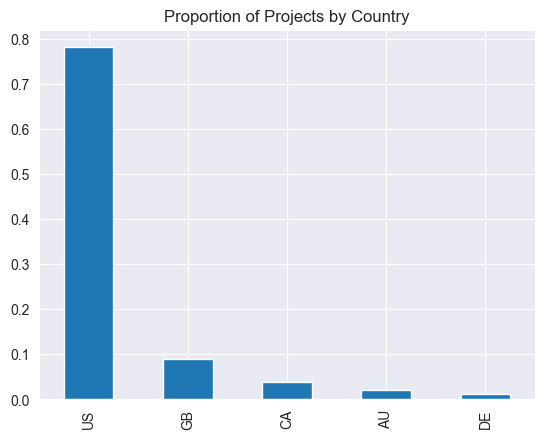

In [7]:
# calculate proportion of projects by country
threshold = 0.01
count_vals = df['country'].value_counts()
proportion = count_vals / df.shape[0]
top_countries = proportion[proportion > threshold]

top_countries.plot(kind="bar")
plt.title("Proportion of Projects by Country");

top_countries

almost 80% of projects are submitted from the US

In [8]:
# filter the dataset to top countries
country_codes = top_countries.index.tolist()
df = df[df['country'].isin(country_codes)]

print(df.shape)

(353065, 15)


almost 20000 projects removed due to small sample size, keeping focus

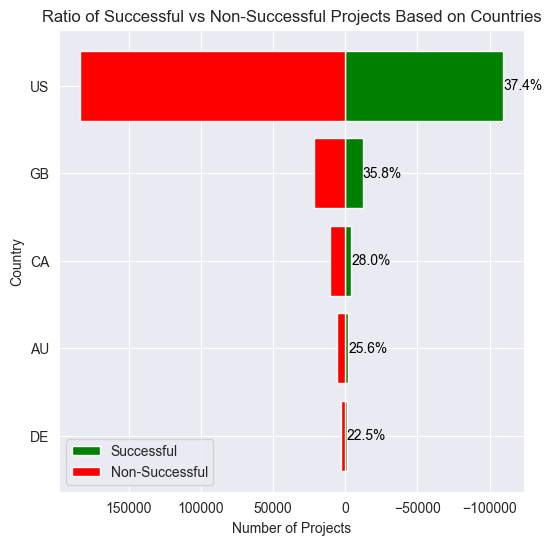

In [9]:
# calculate the success percentage for each country
all_states_data = df.groupby(['country', 'state']).size().unstack().fillna(0)
all_states_data['total'] = all_states_data.sum(axis=1)
all_states_data['success_percentage'] = (all_states_data['successful'] / all_states_data['total']) * 100

# plot the success and failure of projects for each country
sorted_data = all_states_data.sort_values(by='success_percentage', ascending=True)
fig, ax = plt.subplots(figsize=(6, 6))
ax.barh(sorted_data.index, -sorted_data['successful'], color='green')
ax.barh(sorted_data.index, sorted_data['total'] - sorted_data['successful'], color='red')
ax.invert_xaxis()
ax.set_title('Ratio of Successful vs Non-Successful Projects Based on Countries')
ax.set_xlabel('Number of Projects')
ax.set_ylabel('Country')
ax.legend(['Successful', 'Non-Successful'])

# show the success percentage to the right of the bars
for i in range(len(sorted_data)):
    success_percentage = sorted_data['success_percentage'].iloc[i]
    ax.text(-sorted_data['successful'].iloc[i], i, f'{success_percentage:.1f}%', va='center', color='black')

plt.show()

the US and GB are far ahead of project success rate compared to the rest

# Distribution of categories

15 major categories in dataset
159 minor categories in dataset


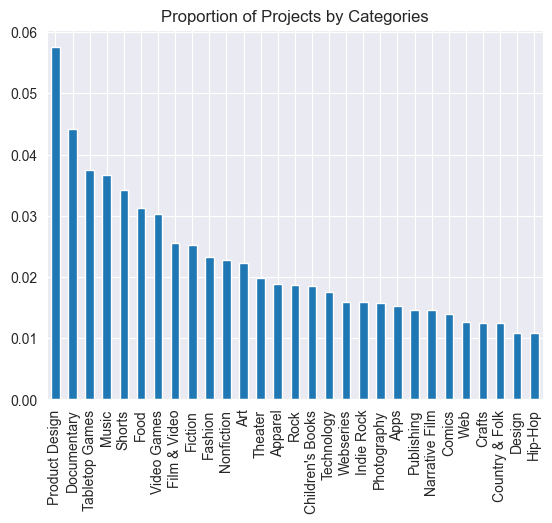

In [10]:
# basic statistics
print(str(len(df.main_category.unique())) + " major categories in dataset")
print(str(len(df.category.unique())) + " minor categories in dataset")

# count categories and proportions
count_vals = df['category'].value_counts()
proportion = count_vals / df.shape[0]
top_categories = proportion[proportion > threshold]

# plot
top_categories.plot(kind="bar")
plt.title("Proportion of Projects by Categories");

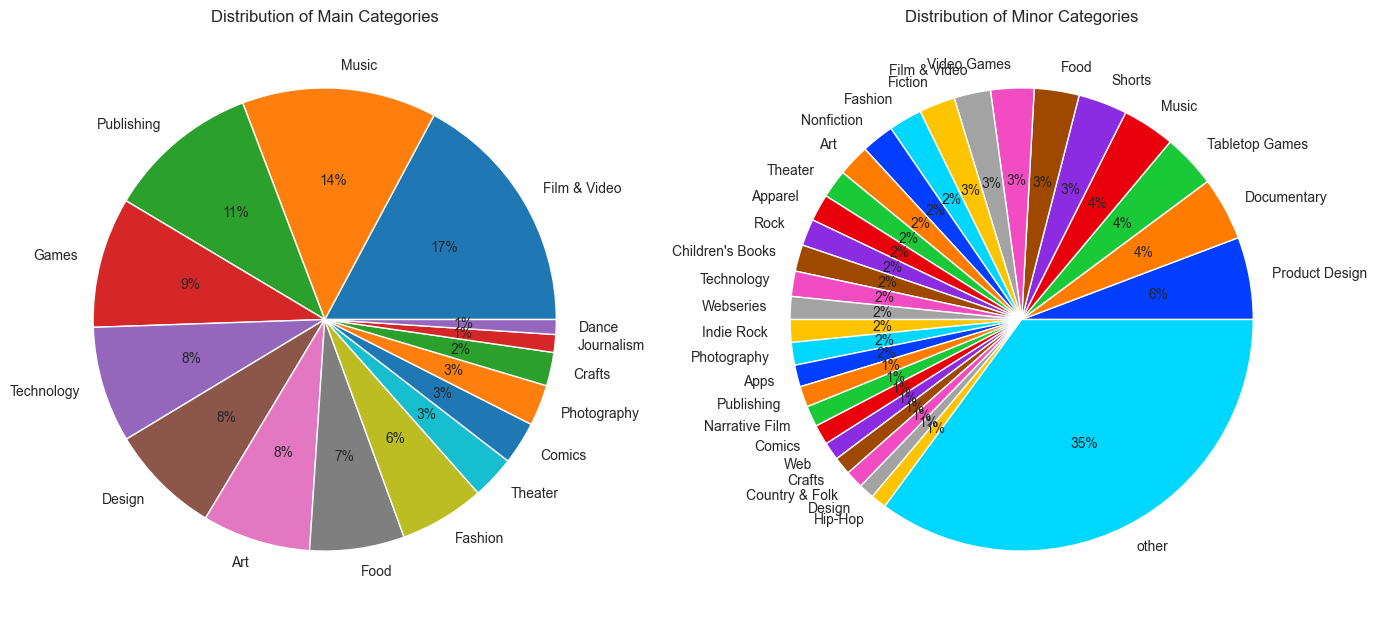

In [11]:
# count categories and aggregate small ones
category_counts = df['category'].value_counts()
small_categories = category_counts[category_counts < threshold * category_counts.sum()].index
other_count = category_counts[small_categories].sum()
category_counts = category_counts.drop(small_categories)
category_counts['other'] = other_count
labels = category_counts.index
counts = category_counts.values

# create chart for main categories
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.set_palette("bright")
plt.pie(df['main_category'].value_counts(), labels=df['main_category'].value_counts().index, autopct='%1.0f%%')
plt.title("Distribution of Main Categories")

# create chart for minor categories
plt.subplot(1, 2, 2)
sns.set_palette("bright")
plt.pie(counts, labels=labels, autopct='%1.0f%%')
plt.title("Distribution of Minor Categories")

plt.tight_layout()
plt.show()

# Connected features

In [12]:
# preprocess the 'state' column for future prediction
df['state_encoded'] = df['state'].map({'successful': 1, 'undefined': float('nan')}).fillna(0)
df = df.dropna(subset=['state_encoded'])
df = df.drop(['state'], axis=1)

# convert the 'deadline' and 'launched' columns to ordinal for regression and correlation then standardize
df['deadline'] = pd.to_datetime(df['deadline']).map(dt.datetime.toordinal)
df['launched'] = pd.to_datetime(df['launched']).map(dt.datetime.toordinal)

df.dtypes

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline              int64
goal                float64
launched              int64
pledged             float64
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
state_encoded       float64
dtype: object

/var/folders/xq/y_v8z095609chhm30y1m19600000gn/T/ipykernel_60145/4082230858.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt=".2f");


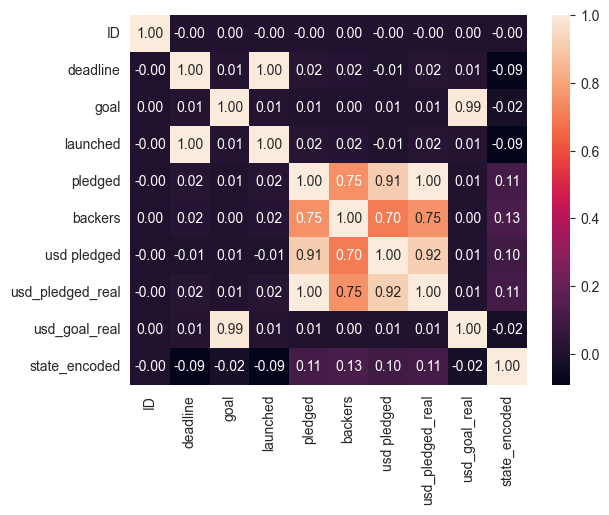

In [13]:
# finding correlations
sns.heatmap(df.corr(), annot=True, fmt=".2f");

<Axes: >

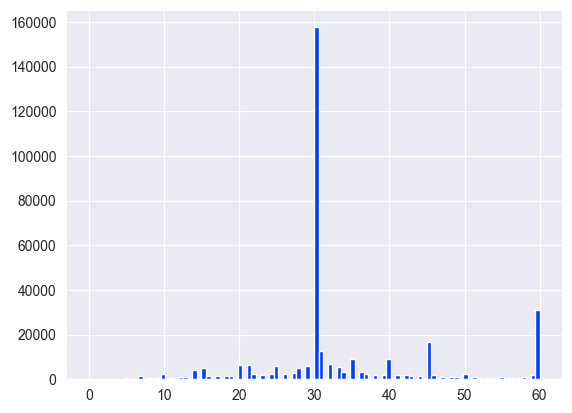

In [14]:
(df.deadline-df.launched).hist(range=[0, 60], bins=100)

Key takeaways
- launched and deadline are correlated due to standard KS 30-day project sizes
- pledged, usd_pledged and usd_pledged_real are correlated strongly as they either move together with currency change or direct linear combinations of each other
- same goes for goal and goal_real
- backers have a connection to pledges (intuitively pledge sizes are not that various while pledge volume goes up with backer number

Thus we can remove irrelevant columns, non-calculated fields regarding money as well as deadline, too

# Predicting success

In [15]:
# select only prior features (that we know of before the launch and remove main category as it is directly linked to category
df = df.drop(['ID', 'name', 'currency', 'usd pledged', 'goal', 'pledged', 'deadline'], axis=1)
df_after = df[['backers', 'usd_pledged_real', 'state_encoded']].copy()
df = df[['category', 'launched', 'country', 'usd_goal_real', 'state_encoded']].copy()


# define a function to clean the dataset for model training
def prepare_data(df):
    """
    Takes a DataFrame, removes rows with missing 'state_encoded' values,
    fills numeric columns with their mean, and dummies categorical variables.
    """
    df = df.dropna(subset=['state_encoded'], axis=0)
    y = df['state_encoded']
    num_vars = df.select_dtypes(include=['number']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in cat_vars:
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)],
                       axis=1)
    X = df
    return X, y, df


# apply the function to prepare for modeling
X, y, df_cleaned = prepare_data(df)

In [16]:
# split into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# use logistic regression for binary results
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_test_preds = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_test_preds)

# proportion of the most frequent class to evaluate model performance
proportion_most_frequent = df['state_encoded'].value_counts().max() / len(df['state_encoded'])
'The accuracy score for the model using logistic regression was {:.3f} on {} values, while based on the distribution {:.3f} would have been achievable.'.format(
    accuracy, len(y_test), proportion_most_frequent)

'The accuracy score for the model using logistic regression was 0.638 on 105920 values, while based on the distribution 0.636 would have been achievable.'